In [1]:
import argparse
import os
import h5py
import numpy as np

from utils01 import ReadXVGs
from utils01 import GROParser
from utils01 import DiscriptorGenerator
from utils04 import LeapFrog

from utils_keras import DNN


DATASETDIR = "workspace/01-make-datasets"
CUTOFF_RADIUS = 1.0
OUTDIR = "workspace/04-simulate"

SCALING_GROUP = [[1], [309]]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--coord', type=str, help='coord file (.xvg)')
parser.add_argument('--init_time', type=int, default=0, help='init time to start simulation')
parser.add_argument('--gro', type=str, help='specify .gro path if want to include amino infomation into datasets')
parser.add_argument('--dataset', type=str,
                    default=os.path.join(DATASETDIR, 'datasets.hdf5'),
                    help='input datasets')

parser.add_argument('--model', type=int, default=1, help='model number')
parser.add_argument('--weights', type=str, nargs=4, required=True, help='model weights (N, CA, C, O)')

parser.add_argument('--len', type=int, default=5000, help='simulation length')
parser.add_argument('-o', type=str, default="trj", help='output name')
parser.add_argument('-k', type=float, default=0, help='spring constant')

a = "--coord input/xvg/2fs/MainChain-coord.xvg --dataset workspace/01-make-datasets/datasets.hdf5 --gro input/solv_ions_prot.gro --weights workspace/03-learning/N/try002/weights/epoch010.hdf5 workspace/03-learning/CA/try002/weights/epoch010.hdf5 workspace/03-learning/C/try002/weights/epoch010.hdf5 workspace/03-learning/O/try002/weights/epoch010.hdf5 --len 100"
# a = "--coord input/2fs/MainChain-coord.xvg --dataset workspace/01-make-datasets/2fs.hdf5 --gro input/topo.gro --weights workspace/03-learning/N/try000/weights/epoch300.hdf5 workspace/03-learning/CA/try000/weights/epoch300.hdf5 workspace/03-learning/C/try000/weights/epoch300.hdf5 workspace/03-learning/O/try000/weights/epoch300.hdf5 --len 100"

args = parser.parse_args(args=a.split())



In [4]:
# ## load gro file ## #
groparser = GROParser(args.gro, CUTOFF_RADIUS)
MAINCHAIN = groparser.mainchains
N_ATOMS = groparser.n_atoms
EACH_N_ATOMS = groparser.each_n_atoms
SLICE_INDECES = groparser.slice_indeces
ARRANGED_INDECES = groparser.arranged_indeces
ADJACENT_INDECES = groparser.adjacent_indeces
AB_INDECES = groparser.ab_indeces
ATOM_ALIGN = groparser.atom_align
CONNECT_INDECES = groparser.connects_indeces
INIT_RADIUSES = groparser.init_radiuses
REARRANGED_INDECES = groparser.rearranged_indeces
RESID_GROUP_INDECES = groparser.resid_group_indeces


In [5]:
fp_force = "input/xvg/2fs/MainChain-force.xvg"
# fp_force = "input/2fs/MainChain-force.xvg"
actual_forces = ReadXVGs(None, None, ARRANGED_INDECES)._read_xvg(fp_force).compute()[:, ARRANGED_INDECES, :]

In [6]:
coords = ReadXVGs(None, None, ARRANGED_INDECES)._read_xvg(args.coord).compute()[:, ARRANGED_INDECES, :]

In [7]:
# ## init strcuct ## #
init_structs = coords[args.init_time:args.init_time+2]


In [8]:
# ## discriptor generator ## #
discriptor_generator = DiscriptorGenerator(
    None, None,
    MAINCHAIN, N_ATOMS, EACH_N_ATOMS, SLICE_INDECES,
    ADJACENT_INDECES, AB_INDECES, ATOM_ALIGN,
    None, None)



In [9]:
# ## read models ## #
inputdims = discriptor_generator.INPUTDIMS
models = {}
for fp in args.weights:
    for atom in MAINCHAIN:
        if f'/{atom}/' in fp:
            dnn = DNN(inputdims[atom], None)
            model = dnn(args.model)
            dnn = DNN(inputdims[atom], None)
            model = dnn(args.model)
            model.load_weights(fp)
            models[atom] = model



In [10]:
# ## normalization values ## #
normalization = {}
with h5py.File(args.dataset, mode='r') as f:
    for atom in MAINCHAIN:
        y_mean, y_std = f[f'/{atom}/normalization'][...]
        normalization[atom] = [y_mean, y_std]



In [11]:
# resid group indeces
group_indeces = []
for resid_list in SCALING_GROUP:
    indeces = sum([RESID_GROUP_INDECES[resid] for resid in resid_list], [])
    group_indeces.append(indeces)


In [12]:
# ## simulate ## #
leapfrog = LeapFrog(discriptor_generator, models, normalization, args.k,
                    N_ATOMS, MAINCHAIN, SLICE_INDECES, ATOM_ALIGN,
                    group_indeces,
                    CONNECT_INDECES, INIT_RADIUSES, inputdims,
                    init_structs)


# pred force

In [13]:
pred_forces = np.empty(actual_forces.shape)
for i, struct in enumerate(coords):
    pred_forces[i] = leapfrog._cal_force(struct)

In [14]:
actual_forces.shape

(101, 1235, 3)

In [15]:
pred_forces.shape

(101, 1235, 3)

In [20]:
diff_forces = np.sqrt(np.sum(np.square(pred_forces - actual_forces), axis=2))
diff_forces.shape

(101, 1235)

In [17]:
SLICE_INDECES

{'N': [0, 309], 'CA': [309, 618], 'C': [618, 927], 'O': [927, 1235]}

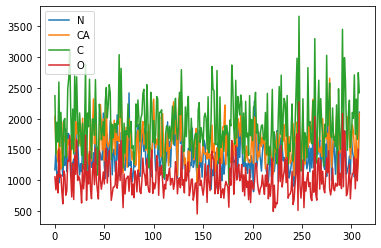

In [21]:
diff_forces_each_atom = np.mean(diff_forces, axis=0)
for atom in MAINCHAIN:
    i, j = SLICE_INDECES[atom]
    diffs = diff_forces_each_atom[i:j]
    plt.plot(diffs, label=atom)

plt.legend()

In [19]:
stop()

NameError: name 'stop' is not defined

In [ ]:
# trj = np.zeros((args.len, N_ATOMS, 3))
# trj[0:2] = init_structs

# for t in range(1, args.len-1):
#     trj[t+1] = leapfrog(trj[t-1], trj[t])
#     print('\r', t+2, '/', args.len, end="")
# print()

# trj = trj[:, REARRANGED_INDECES, :]


# cal force

In [ ]:
# ## cal force ## #
def cal_force(discriptors):
    discriptors = np.tile(discriptors, (N_ATOMS, 1)).reshape(N_ATOMS, -1, 3)
    discriptors = discriptors - discriptors.transpose(1, 0, 2)

    discriptor, rot_matrices = discriptor_generator._descriptor(discriptors)

    forces = np.zeros((N_ATOMS, 3))
    for atom in MAINCHAIN:
        i, j = SLICE_INDECES[atom]
        force = model[atom].predict(discriptor[i:j])
#         y_mean, y_std = normalization[atom]
#         force = np.add(np.multiply(force, y_std), y_mean)
        forces[i:j] = force

    # rotate
    forces = np.array([np.dot(force, np.linalg.inv(rot_matrix)) for force, rot_matrix in zip(forces, rot_matrices)])

    return forces


In [ ]:
pred = np.array([cal_force(coord) for coord in coords])
pred.shape

In [ ]:
for atom in MAINCHAIN:
    i, j = SLICE_INDECES[atom]
    y_mean, y_std = normalization[atom]
    forces[:, i:j, :] = np.divide(np.subtract(forces[:, i:j, :], y_mean), y_std)

In [ ]:
trjlen = 100
atomlist = [0,1,2]

fig = plt.figure(figsize=(30,8*len(atomlist)))
for i, atom in enumerate(atomlist):
    for x in [0,1,2]:
        ax = fig.add_subplot(len(atomlist), 3, x+i*3+1)
        ax.plot(pred[:trjlen, atom, x])
        ax.plot(forces[:trjlen, atom, x])

In [ ]:
x = pred-forces

In [ ]:
np.mean(np.square(x))